## Import Data + Basic Functions

In [684]:
import pandas as pd
import numpy as np
import math

relevant_columns = ['player', 'player_id', 'position', 'team_name', 'player_game_count',
       'avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
       'yards_after_catch_per_reception', 'yards_per_reception', 'yprr']
new_columns = ['fpts', 'fpts_game', 'targets_game', 'touchdowns_game']

def import_history (years, columns=relevant_columns, new_columns=new_columns, replace=np.nan, remove_lists=True, targ_quant=0.25):
    # import one csv file for each year
    # return in a dict with each dataframe
    dataframes = {}
    for year in years:
        location = 'Yearly\\' + str(year) + '.csv'
        df = pd.read_csv(location)
        df = df[df['position'] == 'WR']
        df = df[df['targets'] >= df['targets'].quantile(targ_quant)]
        
        # calcualte fantasy points
        df['fpts'] = df['receptions'] * 0.5 + df['yards'] * 0.1 + df['touchdowns'] * 6
        # calculate per game metrics
        df['fpts_game'] = df['fpts'] / df['player_game_count']
        df['targets_game'] = df['targets'] / df['player_game_count']
        df['touchdowns_game'] = df['touchdowns'] / df['player_game_count']
        df_columns = columns + new_columns
        df = df[df_columns]
        df['year'] = year
        dataframes[year] = df
    
    #combine all csvs into one
    wr_data = pd.concat(list(dataframes.values()))
    wr_data_names = pd.DataFrame(wr_data['player'].unique()).copy()
    wr_data_names.columns = ['player']

    #select numeric data columns
    data_columns = list(df.select_dtypes(include=[np.number]).columns)
    data_columns.remove('player_id')
    data_columns.remove('year')

    #aggregate data by creating a list of all values for each stat that occured before the given year
    wr_df_list = []
    for year in years:
        if year == 2018: continue
        wr_data_split = wr_data_names.copy()
        for column in data_columns:
                df = wr_data[wr_data['year'] < year].groupby('player')[column].apply(list).reset_index()
                wr_data_split = pd.merge(wr_data_split, df, 'inner', 'player')
        wr_data_split['year'] = year
        wr_df_list.append(wr_data_split)

    #store raw values here
    wr_data_raw = pd.concat(wr_df_list).reset_index(drop=True)
    wr_data_raw = pd.merge(wr_data_raw, wr_data[['player', 'year', 'fpts_game']], 'left', ['player', 'year'])
    wr_data_raw.rename(columns={'fpts_game_x': 'fpts_game', 'fpts_game_y': 'fpts_game_actual'}, inplace=True)
    wr_data_raw = wr_data_raw.dropna(subset=['fpts_game_actual']).reset_index(drop=True)

    #create new dataframe that stores the std, mean and slope for each list of values
    for column in data_columns:
        wr_data_raw[column + '_std'] = np.array(np.std(pd.DataFrame(wr_data_raw[column].tolist()),axis=1))
        wr_data_raw[column + '_mean'] = np.array(np.mean(pd.DataFrame(wr_data_raw[column].tolist()),axis=1))
        wr_data_raw[column + '_slope'] = np.array((np.max(pd.DataFrame(wr_data_raw[column].tolist()),axis=1) 
                            - np.min(pd.DataFrame(wr_data_raw[column].tolist()),axis=1)) 
                            / pd.DataFrame(wr_data_raw[column].tolist()).notna().sum(axis=1))

    # split the values for year such that data is broken into: last year, two years ago...
    if len(years) > 1:
        def year_split(column, input):
            df = input.copy()
            for year in range(6):
                year = (year + 1)
                year_neg = year * -1
                column_name = column + str(year_neg)
                df[column_name] = [x[year_neg] if len(x) >= year else replace for x in df[column]]
            return df
        for column in data_columns:
            wr_data_raw = year_split(column, wr_data_raw)
    if relevant_columns:
        wr_data_raw = wr_data_raw[['player']].join(wr_data_raw.select_dtypes('number'))

    return wr_data_raw

# types: years(values split by year), stats(values split by stats), all
def df_select(input, columns, kind='both', addl_col = []):
    basics = ['player','year','fpts_game_actual'] + addl_col
    years = ['-1','-2','-3','-4','-5','-6']
    stats = ['_std','_mean','_slope']
    both = years + stats
    options = {'years': years,'stats':stats, 'both':both}
    suffixs = options[kind]
    df = input.copy()
    columns = [col + suffix for col in columns for suffix in suffixs]
    columns_all = basics + columns
    df = df[columns_all]
    return df, columns

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import matplotlib.pyplot as plt

def lr_predict (df,attributes,target,rand,chart=False,print_out=True, error=[]):
    columns = attributes + error
    X = df[columns].copy()
    # X = X.apply(zscore)
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand)

    lr = LinearRegression()
    lr.fit(X_train[attributes], y_train)
    r_score = lr.score(X_test[attributes],y_test)
    if print_out: print('R score ',r_score)

    if chart == True:
        y_1 = lr.predict(X_test[attributes])
        plt.scatter(y_1,y_test)
        x = y = np.arange(min(y),max(y))
        plt.plot(x, y)
        if error != []:
            plt.errorbar(y_1,y_test,yerr=X_test[error])
    
    slope = lr.coef_
    intercept = lr.intercept_
    if print_out: print('Slope', slope)
    if print_out: print('Intercept', intercept)
    return r_score, slope, intercept, lr

## Classification RF

### PCT Likelyhood model

In [741]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from scipy.stats import pearsonr

data_columns_base = ['avg_depth_of_target', 'slot_rate', 'targeted_qb_rating', 'targets', 'touchdowns', 'wide_rate',
    'yards_after_catch_per_reception', 'yards_per_reception', 'yprr', 'fpts', 'fpts_game', 'targets_game', 'touchdowns_game']


def rf_prob_sub(wr, data_columns=data_columns_base, test_year=2024, estimators=500, rand_seed=1, top_features=20, display_chart=False):
    #add rounding with maximum and minimum values
    wr['fpts_game_actual_round'] = wr['fpts_game_actual'].round()
    wr.loc[wr['fpts_game_actual_round'] > 17, 'fpts_game_actual_round'] = 17
    wr.loc[wr['fpts_game_actual_round'] < 3, 'fpts_game_actual_round'] = 3
    bins = list(range(3,18))

    #breakout data columns
    if data_columns == data_columns_base:
        wr, data_columns = df_select(wr, data_columns, kind='both', addl_col=['fpts_game_actual_round'])

    #split into test and tain sets
    wr_train = wr[wr['year']!=test_year].reset_index(drop=True)
    wr_test = wr[wr['year']==test_year].reset_index(drop=True)

    # Features and target variable
    X = wr[data_columns]
    y = wr['fpts_game_actual_round']

    # train test split
    X_train, y_train = wr_train[data_columns].to_numpy(), wr_train['fpts_game_actual_round'].to_numpy()
    X_test, y_test = wr_test[data_columns].to_numpy(), wr_test['fpts_game_actual_round'].to_numpy()

    # Train a Random Forest classifier
    model = RandomForestClassifier(n_estimators=estimators, random_state=rand_seed)
    model.fit(X_train, y_train)

    # Predict probabilities for each category
    probs = model.predict_proba(X_test)
    prediction = model.predict(X_test)

    # use weighted average of probabilities for each bin to find mean prediction
    results = pd.DataFrame(probs, columns=bins)
    results['mean_pred'] = results[bins].to_numpy()@np.array(bins)
    results['actual'] = y_test

    #use pct predictions for each bin to find std
    bins_std = (pd.DataFrame(probs, columns=bins)*100).round().astype(int)
    bins_list = []
    for x in bins:
        name = str(x) + 'p'
        bins_list.append(name)
        bins_std[name] = bins_std[x].apply(lambda y: [x] * int(y))
    stds = [np.concatenate(row).std() for row in bins_std[bins_list].to_numpy()]
    results['std'] = stds
    results['player'] = wr_test['player']

    # Calculate portion within 1 std and use predicted vs actual to find Rscore
    results['high'] = results['mean_pred'] + results['std']
    results['low'] = results['mean_pred'] - results['std']
    results['in'] = (results['actual'] <= results['high']) & (results['actual'] >= results['low'])
    results['high'] = results['actual'] >= results['high']
    results['low'] = results['actual'] <= results['low']
    score = sum(results['in'].astype(int))/len(results)
    # print('Pct within 1 std: {}%'.format(round(score*100)))
    rscore,_,_,_ = lr_predict(results,['mean_pred'], 'actual', 30, False, False)
    p_corr, p = pearsonr(results['mean_pred'], results['actual'])

    # Get numerical feature importances
    importances = list(model.feature_importances_)
    feature_importances = [[feature, round(importance, 3)] for feature, importance in zip(data_columns, importances)]
    feature_importances = np.array(sorted(feature_importances, key = lambda x: x[1], reverse = True))
    most_val_features = feature_importances[0:top_features]

    # filter to 2024 and plot results
    if display_chart: 
        results_display = results.sort_values(by='mean_pred',ascending=True).copy()
        plt.figure(figsize=(10,20))
        plt.barh(results_display['player'], results_display['mean_pred'], xerr=results_display['std'], capsize=5)
        plt.plot(results_display['actual'], results_display['player'], 'o', color='red')
        plt.tight_layout()

    
    return score, rscore, p_corr, most_val_features, results[['player','mean_pred', 'std','actual']]



### apply model

0.7395117302317278

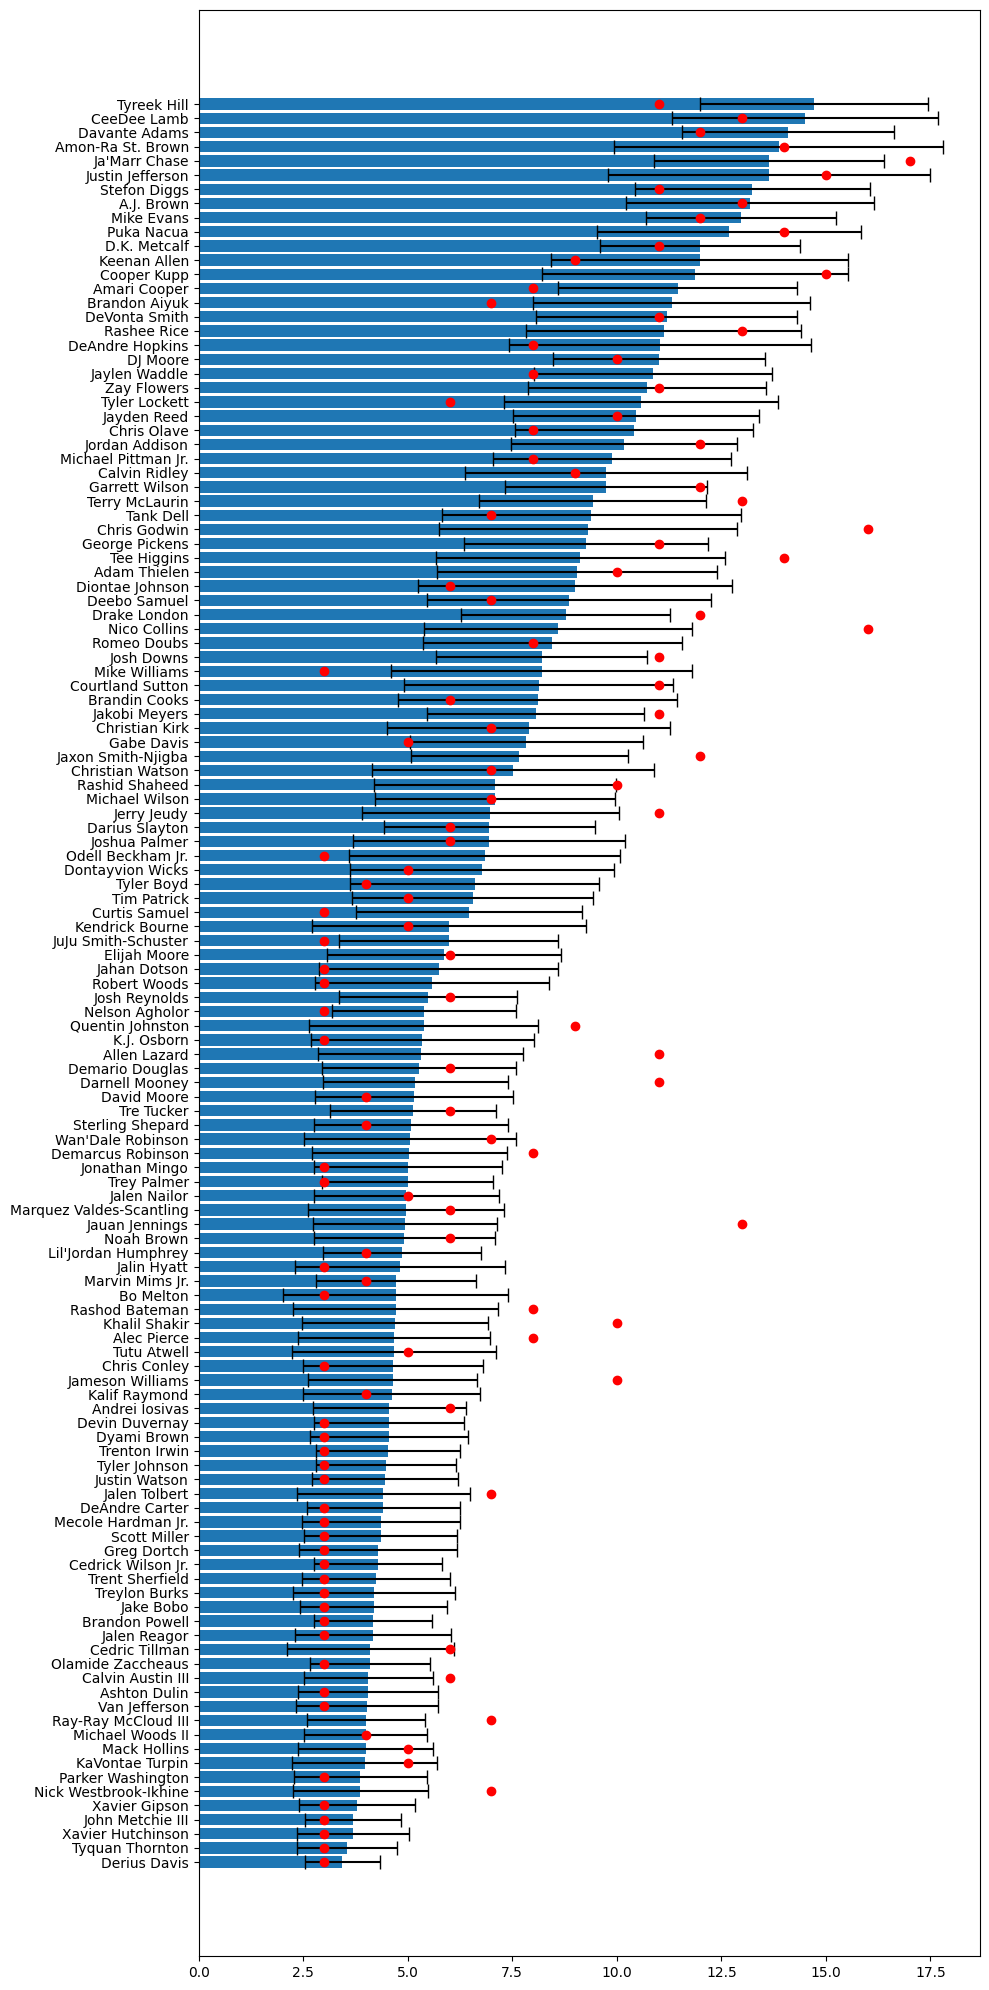

In [742]:
#import data
years = [2018,2019,2020,2021,2022,2023,2024]
wr = import_history(years)
# data_columns = [s for s in wr.columns if 'mean' in s]

# seeds = [1,2,3,4,5,6,7,8,9,10]
year = 2024
# for estm in [100,500,2000]:    
#     rscores = []
#     scores = []
#     for seed in seeds:
#         score, rscore, fts = rf_prob_sub(wr, test_year=year, estimators=estm, rand_seed=seed)
#         # score, rscore, fts = rf_prob_sub(wr, data_columns=fts[:,0].tolist(), test_year=year, estimators=400, top_features=20, rand_seed=seed)
#         rscores.append(rscore)
#         scores.append(score)
        
#     print(estm)
#     print(np.mean(rscores))
#     print(np.mean(scores))

score, rscore, p_corr, fts, results = rf_prob_sub(wr, test_year=year, estimators=100, rand_seed=1, display_chart=True)
p_corr

## Neural Network

In [769]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# define class
class NN:
    def __init__(self,input_array, target, test_years=[2021,2022,2023,2024], layer_size=[15,1], layer_sigmoid=[True, False], iterations=10, learning_rate=0.0001):
        self.lr = learning_rate
        self.iterations = iterations
        self.input_array = input_array
        self.target_col = target
        self.base_cols = ['player','year',target]
        self.target_vector = self.input_array[target]
        # Set input columns
        self.attribute_cols = input_array.columns.drop('year').drop('player').drop(target)
        # Set layer parameters
        self.layer_size = layer_size
        self.layer_sigmoid = layer_sigmoid

        # Normalize data
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(self.input_array[self.attribute_cols]), columns=self.attribute_cols)
        self.input_array_scaled = self.input_array[self.base_cols].join(df_scaled)

        # Split train test data
        self.test_years = test_years #chosen since there is sufficient historical data for these years (starting in 2018)
        # Define train set attributes
        self.train_set = []
        self.train_set_target = []
        # Define test set attributes
        self.test_set = []
        self.test_set_target = []
        # Iterate over testing years
        for i, year in enumerate(self.test_years):
            # create list of train/test input dataframes
            self.train_set.append(self.input_array_scaled[self.input_array_scaled['year']!=year].reset_index(drop=True)[self.attribute_cols])
            self.test_set.append(self.input_array_scaled[self.input_array_scaled['year']==year].reset_index(drop=True)[self.attribute_cols])
            # find number of samples for each test year
            train_samples = len(self.train_set[i])
            test_samples = len(self.test_set[i])
            # create list of train/test target arrays
            self.train_set_target.append(np.array(self.input_array_scaled[self.input_array_scaled['year']!=year].reset_index(drop=True)[self.target_col]).reshape(train_samples,1))
            self.test_set_target.append(np.array(self.input_array_scaled[self.input_array_scaled['year']==year].reset_index(drop=True)[self.target_col]).reshape(test_samples,1))

        # create initial weights and biases 
        self.weights = []
        self.biases = []
        sizes = [len(self.attribute_cols)] + self.layer_size
        for i in range(len(sizes)-1):
            self.weights.append(np.random.rand(sizes[i], sizes[i+1]) - 0.5)
            self.biases.append(np.random.rand(sizes[i+1]))

        # create list holders for foward pass outputs and intermediates
        self.forward_output = []
        self.forward_med = []

    def _randomize (self, limit_attributes=[]):
        # set the length based on desired input attributes
        input_len = len(self.attribute_cols)
        if len(limit_attributes)>0:
            input_len = len(limit_attributes)

        # output lists
        weights = []
        biases = []

        # create weights and biases to matched the desired layer sizes
        sizes = [input_len] + self.layer_size
        for i in range(len(sizes)-1):
            weights.append(np.random.rand(sizes[i], sizes[i+1]) - 0.5)
            biases.append(np.random.rand(sizes[i+1]))

        # set outputs
        self.weights = weights
        self.biases = biases

    # Define sigmoid forward and backward
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def _sigmoid_deriv(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))
    
    # Define forward step
    def _forward_step (self, input, weight, bias):
        intermediate = np.dot(input, weight) + bias
        output = self._sigmoid(intermediate)
        return output, intermediate
    
    # Combine forward passes for each layer
    def _forward_pass (self, sample_set, limit_attributes=[]):
        # set limited attributes if selected
        attributes = self.attribute_cols
        if limit_attributes != []:
            attributes = limit_attributes

        # run based of of which of the traing sets to use
        input = self.train_set[sample_set][attributes]
        # Output lists
        self.forward_med = []
        self.forward_output = []

        for layer in range(len(self.layer_size)):
           # perform a forward step for each layer
           output, intermediate = self._forward_step(input, self.weights[layer], self.biases[layer])
           # set the next input to this layers output. If no sigmoid then stop at intermediate result 
           input = output
           if not self.layer_sigmoid[layer]:
               input = output = intermediate
           self.forward_med.append(intermediate)
           self.forward_output.append(output)
        return output
    
    # based on results of forward pass, compute the gradients for each weight and bias
    def _backward_pass (self, sample_set, limit_attributes=[]):
        # set limited attributes if selected
        attributes = self.attribute_cols
        if limit_attributes != []:
            attributes = limit_attributes
        
        # Ouput lists
        weights_delta = []
        bias_delta = []
        # create lists for the inputs and output from each layer
        layer_inputs = [self.train_set[sample_set][attributes].to_numpy()] + self.forward_output[:-1]
        d_outputs = [2*(self.forward_output[-1] - self.train_set_target[sample_set])]

        for layer in range(len(self.layer_size)):
            # Take inverse to go backwards through list
            layer = -1 - layer
            # Set input output and intermediate values for layer
            layer_input = layer_inputs[layer]
            layer_output_der = d_outputs[-1]
            layer_intermediate = self.forward_med[layer]
            # Calculate sigmoid derivitive, but overwrite is sigmoid not in this layer
            if self.layer_sigmoid[layer]:
                sigmoid_result = self._sigmoid_deriv(layer_intermediate)
            else:
                # sigmoid_result = layer_intermediate   
                sigmoid_result = 1
            # Calculate weights gradient (weights transposed dot (sigmoid result * derivitive of output))         
            grad_weights = np.dot(layer_input.T, sigmoid_result * layer_output_der)
            weights_delta.append(grad_weights * self.lr)
            # Calculate bias gradient (column-wise sum of (sigmoid result * derivitive of output))
            grad_bias = np.sum(sigmoid_result * layer_output_der, axis=0)
            bias_delta.append(grad_bias * self.lr)
            # Calculate derivitive of input to be used in next layer ((sigmoid result * derivitive of output) dot weights transposed)
            d_input = np.dot(sigmoid_result * layer_output_der, self.weights[layer].T)
            d_outputs.append(d_input)

        return weights_delta[::-1], bias_delta[::-1]

    # iterate through forward and backward passes to train model
    def build_model (self, sample_set, iterations, limit_attributes=[]):
        # set weights and biases to new random values
        self._randomize(limit_attributes)
        # run the process for each iteration
        errors = []
        for _ in range(iterations):
            # forward and backwards
            prediction = self._forward_pass(sample_set, limit_attributes)
            w_delta, b_delta = self._backward_pass(sample_set, limit_attributes)
            # calculate error
            error = np.sum((prediction - self.train_set_target[sample_set])**2)
            errors.append(error)
            # update weights and biases
            for layer in range(len(self.layer_size)):
                self.biases[layer] -= b_delta[layer]
                self.weights[layer] -= w_delta[layer]
                
        prediction = self._forward_pass(sample_set,limit_attributes)
        return prediction, errors
    
    def test_model (self, sample_set, limit_attributes=[], charts=False):
        # set limited attributes if selected
        attributes = self.attribute_cols
        if limit_attributes != []:
            attributes = limit_attributes

        # run based of of which of the traing sets to use
        input = self.test_set[sample_set][attributes]

        # did not use _forward_pass so not update the class values
        # switch later, not an issue
        for layer in range(len(self.layer_size)):
           # perform a forward step for each layer
           output, intermediate = self._forward_step(input, self.weights[layer], self.biases[layer])
           # set the next input to this layers output. If no sigmoid then stop at intermediate result 
           input = output
           if not self.layer_sigmoid[layer]:
               input = output = intermediate
        prediction = output
        
        # find pearson correlation and p value (-1,1)
        corr, p = pearsonr(prediction, self.test_set_target[sample_set])
        if charts:
            plt.scatter(prediction, self.test_set_target[sample_set])
            plt.annotate('Corr: ' + str(np.round(corr,2)), (0.05, 0.95), xycoords='axes fraction')
            plt.annotate('P: ' + str(np.round(p,10)), (0.05, 0.85), xycoords='axes fraction')
            # plt.show()
        
        return corr, p, prediction
    
    # print chart that lists draft predictions along with actuals
    def print_draft (self, year, predictions):
        df = self.input_array_scaled[self.input_array_scaled['year'] == year].copy()

        df['prediction'] = predictions
        df.sort_values(by='prediction',inplace=True)

        plt.figure(figsize=(10,20))
        plt.barh(df['player'], df['prediction'])
        plt.plot(df['fpts_game_actual'], df['player'], 'o', color='red')
        plt.tight_layout()


    # build and test together for all cross validated sets of years
    def build_test_all_samples (self, iterations, limit_attributes=[], print_stats=True, print_test_plot=False, print_draft_year=0, top_attributes_num=10, rand_seed=1):
        np.random.seed = rand_seed
        # output lists
        predictions = []
        actuals = []

        # iterate over each test year
        for sample in range(len(self.test_set)):
            prediction, error = self.build_model(sample, iterations, limit_attributes)
            corr, _ , prediction= self.test_model(sample, limit_attributes, print_test_plot)   
            predictions.append(prediction)
            actuals.append(self.test_set_target[sample]) 

        # combine all test years and find correlation to actuals
        predictions_conc = np.concatenate(predictions)
        actuals = np.concatenate(actuals)
        corr, p = pearsonr(predictions_conc, actuals)
        # p-test at 99.9%
        p_test = 'fail'
        if p < 0.001: p_test = 'pass'

        # print draft list for given year
        year_sample = print_draft_year - 2021
        if print_draft_year != 0:
            self.print_draft(print_draft_year, predictions[year_sample])

        # print statistical results
        if print_stats:
            print(f'Correlation: {corr[0]:.2f}')
            print('p test 99.9%: ', p_test)

        # get top x hihghest weighted attributes from layer 1
        input_attributes = self.attribute_cols
        if limit_attributes != []: input_attributes = limit_attributes
        weight1_mag = np.sqrt(np.sum(self.weights[0]**2,axis=1)).reshape(-1,1)
        attributes = np.array(input_attributes).reshape(-1,1)
        weight_attributes = np.hstack([weight1_mag, attributes])
        top_attributes = list(weight_attributes[weight_attributes[:,0].argsort()[::-1]][:top_attributes_num,1])

        return corr, p, top_attributes

    def predict (self, input):
        # run based of of which of the traing sets to use
        input = input
        # Output lists
        self.forward_med = []
        self.forward_output = []

        for layer in range(len(self.layer_size)):
           # perform a forward step for each layer
           output, intermediate = self._forward_step(input, self.weights[layer], self.biases[layer])
           # set the next input to this layers output. If no sigmoid then stop at intermediate result 
           input = output
           if not self.layer_sigmoid[layer]:
               input = output = intermediate
           self.forward_med.append(intermediate)
           self.forward_output.append(output)
        return output
    

### apply model

In [757]:
# rule for layer starting size: 10x more data than number of multipliers + biases
# 400 data points, stay below ~50 parameters
# need to reduce number of data attributes, currently 100, down to ~10

years = [2018,2019,2020,2021,2022,2023,2024]
wr = import_history(years,replace=0)
target_col = 'fpts_game_actual'
layers = [{'type': 'sigmoid', 'size': 10}, {'type': 'dot', 'size': 10}]

# build inital model
layer_1 = 15
my_nn = NN(wr, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)

# calculate parameter count
# parameters = 0
# for layer in range(len(my_nn.layer_size)):
#     parameters += my_nn.weights[layer].shape[0] * my_nn.weights[layer].shape[1]
#     parameters += my_nn.biases[layer].shape[0] * my_nn.biases[layer].shape[0]
# print('parameters: ', str(parameters))

# select the top 20 attributes my magnitude
corr, p, top_attributes = my_nn.build_test_all_samples(500, top_attributes_num=20)
print(top_attributes, '\n')
# narrow to the top 5 attributes
corr, p, top_attributes = my_nn.build_test_all_samples(500,limit_attributes=top_attributes, top_attributes_num=5)
print(top_attributes, '\n')
# with only 5 attributes we can build a model that has more parameters ~50 > ~10 in layer 1

# build new model with 10 neurons at layer 1
layer_1 = 10
my_nn = NN(wr, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
corr, p, top_attributes = my_nn.build_test_all_samples(400,limit_attributes=top_attributes)

# compute standard deviation
layer_1 = 10
my_nn = NN(wr, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
corr, p, top_attributes = my_nn.build_test_all_samples(300,limit_attributes=top_attributes)

Correlation: 0.77
p test 99.9%:  pass
['fpts_mean', 'fpts_game_mean', 'targets-1', 'slot_rate-1', 'fpts-1', 'touchdowns_mean', 'wide_rate_mean', 'yprr-1', 'targets_mean', 'fpts_game-1', 'wide_rate-2', 'touchdowns-1', 'targets_game-1', 'targets-2', 'yards_per_reception_std', 'slot_rate-2', 'slot_rate_mean', 'avg_depth_of_target_mean', 'fpts-2', 'wide_rate-5'] 

Correlation: 0.78
p test 99.9%:  pass
['fpts_mean', 'fpts-1', 'yprr-1', 'fpts-2', 'wide_rate_mean'] 

Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass
Correlation: 0.78
p test 99.9%:  pass


In [803]:
layer_1 = 10
my_nn = NN(wr, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
df_std = my_nn.input_array_scaled.loc[my_nn.input_array_scaled['year'] == 2024, ['player','fpts_game_actual']]

name_list = []
for x in range(10):
    name = 'pred_' + str(x)
    name_list.append(name)
    corr, p, top_attributes = my_nn.build_test_all_samples(300,limit_attributes=top_attributes, rand_seed=x, print_stats=False)    
    predictions = my_nn.predict(my_nn.test_set[3][top_attributes])
    df_std[name] = predictions

df_std['std'] = np.std(df_std[name_list],axis=1)
df_std['pred_mean'] = np.mean(df_std[name_list],axis=1)
df_std[['player','fpts_game_actual','pred_mean','std']]

,player,fpts_game_actual,pred_mean,std
645,DeAndre Hopkins,8.115385,11.644528,0.159974
646,Davante Adams,11.920000,14.018779,0.037055
647,JuJu Smith-Schuster,3.320000,6.152707,0.027341
648,Robert Woods,1.518182,6.936799,0.103623
649,Adam Thielen,10.450000,10.419096,0.087799
...,...,...,...,...
765,Jake Bobo,1.069231,3.700542,0.152239
766,Xavier Hutchinson,0.875000,2.505744,0.153914
767,Parker Washington,2.969231,2.837122,0.089437
768,KaVontae Turpin,4.569231,3.197123,0.080362


In [815]:
multiplier = 26
df = df_std.copy()
df['std'] = df['std'] * multiplier
df['in'] = [1 if (actual <= (mean+std)) and (actual >= (mean-std)) else 0 for actual, mean, std in zip(df['fpts_game_actual'], df['pred_mean'], df['std'])]
df['in'].sum()/len(df)

df[df['in']==False][['player','fpts_game_actual','pred_mean','std']]
df[(df['pred_mean']-df['std']) > df['fpts_game_actual']][['player','fpts_game_actual','pred_mean','std']]

,player,fpts_game_actual,pred_mean,std
646,Davante Adams,11.920000,14.018779,0.963430
647,JuJu Smith-Schuster,3.320000,6.152707,0.710863
648,Robert Woods,1.518182,6.936799,2.694194
650,Tyreek Hill,10.723077,15.701047,2.266648
651,Stefon Diggs,11.387500,13.636031,1.048497
653,Keenan Allen,9.145455,12.004906,1.546024
654,Mike Evans,12.250000,13.994664,1.620457
655,Amari Cooper,7.827273,12.071877,2.832886
656,Odell Beckham Jr.,1.111111,7.970901,3.946691
657,Tyler Boyd,3.707692,7.894177,1.629626


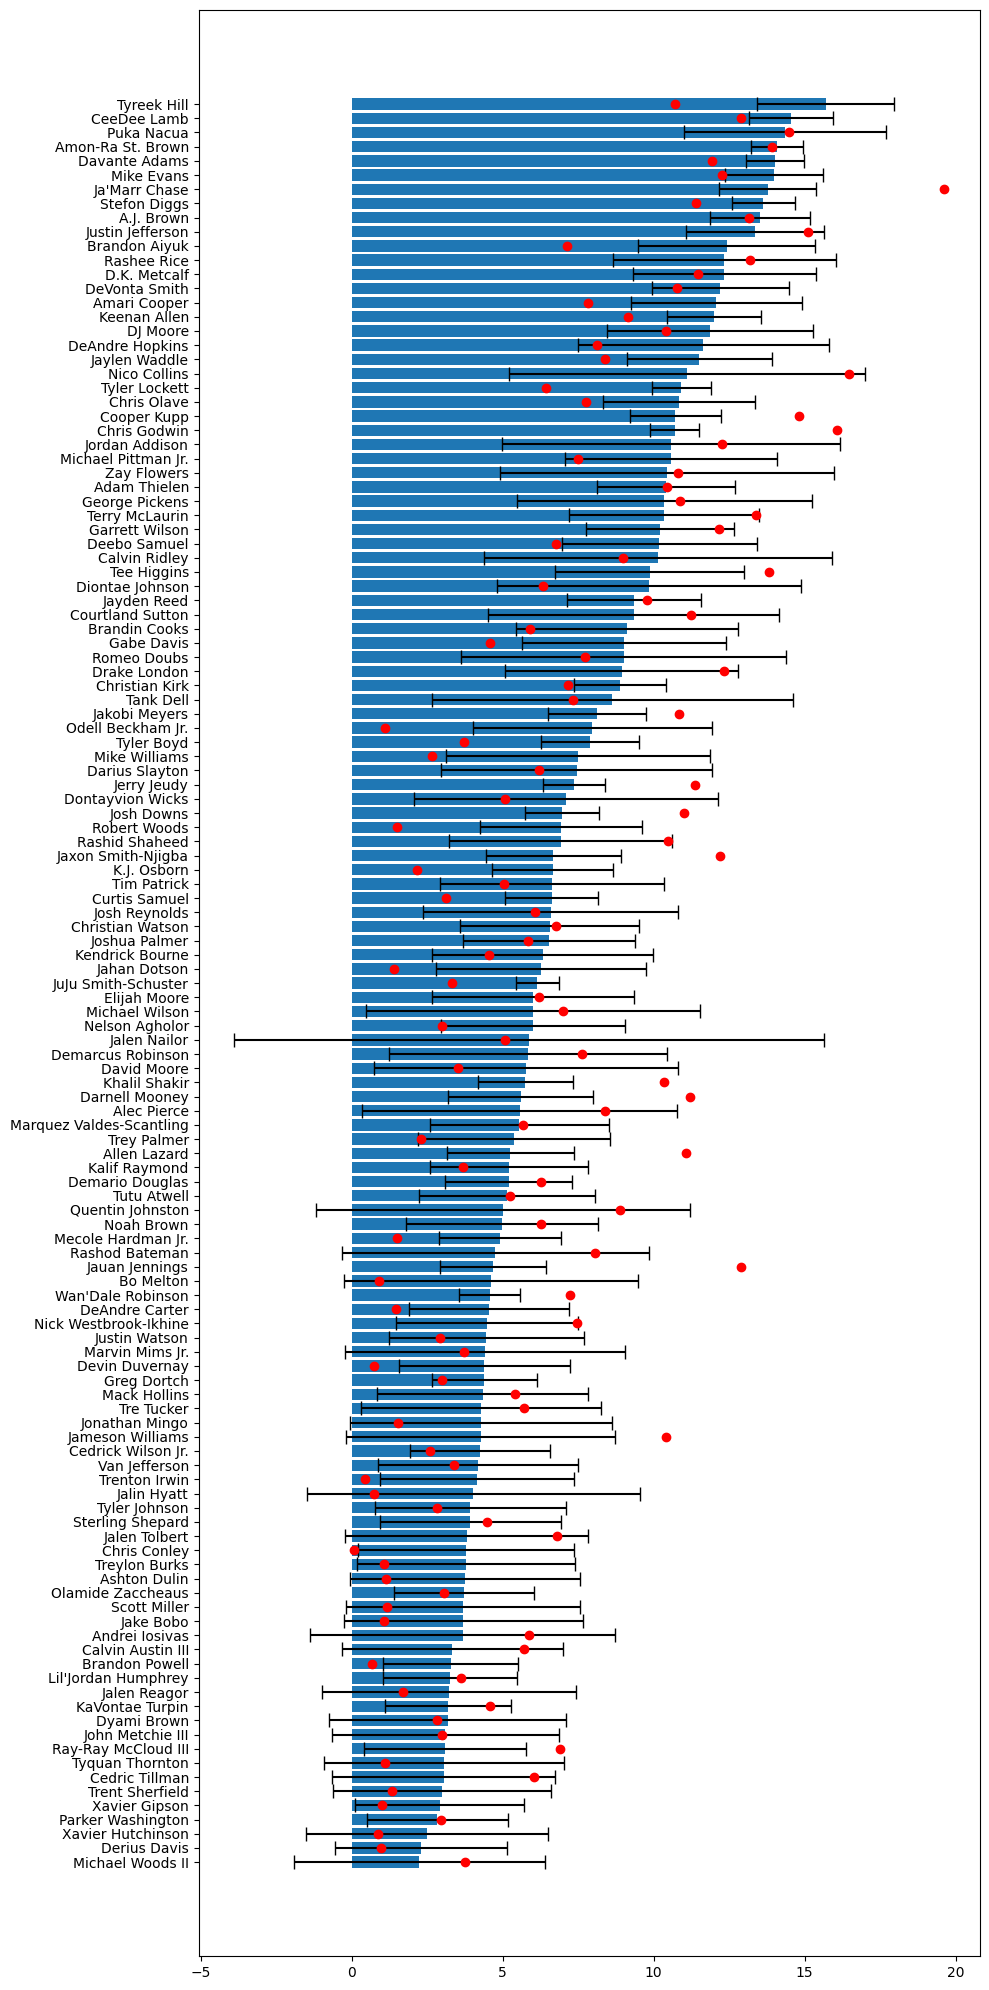

In [810]:
results_display = df.sort_values(by='pred_mean',ascending=True)
plt.figure(figsize=(10,20))
plt.barh(results_display['player'], results_display['pred_mean'], xerr=results_display['std'], capsize=5)
plt.plot(results_display['fpts_game_actual'], results_display['player'], 'o', color='red')
plt.tight_layout()

### ID high/low players

## Test against ADP
instead of just testing the correlation find the actual performance compared to average draft position

In [731]:
# source: https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2021
from scipy.stats import norm

def import_adps (years = [2021, 2022, 2023, 2024]):
    years = years
    dfs = []
    for year in years:
        file = 'adp_' + str(year) + '.csv'
        df = pd.read_csv(file)
        df['year'] = year
        dfs.append(df)
    adp = pd.concat(dfs).reset_index(drop=True)
    adp.dropna(subset=['POS'],inplace=True)
    adp = adp[(adp['POS'].str.contains('WR'))&(adp['Rank']<300)]
    adp['max'] = np.max(adp[['ESPN','Sleeper', 'NFL', 'RTSports']], axis=1)
    adp['ESPN'] = adp['ESPN'].fillna(adp['max'])
    adp['Sleeper'] = adp['Sleeper'].fillna(adp['max'])
    adp['NFL'] = adp['NFL'].fillna(adp['max'])
    adp['RTSports'] = adp['RTSports'].fillna(adp['max'])
    adp.drop('FFC', axis=1, inplace=True)
    adp['std'] = np.std(adp[['ESPN','Sleeper', 'NFL', 'RTSports']],axis=1)
    adp = adp[['Player', 'AVG', 'std', 'year']]

    return adp.reset_index(drop=True)

def create_draft (input, year, size=84):
    draft = np.array(['Player', 'AVG', 'std', 'year', 'prob', 'cutoffs'])
    df = input[input['year']==year].copy()
    picks = np.array(range(size)) + 1.5
    for pick in picks:
        
        df['prob'] = norm.cdf(pick, loc=df['AVG'], scale=df['std'])
        df['prob'] = df['prob']/df['prob'].sum()
        cutoffs = list(df['prob'])
        cutoffs = [sum(cutoffs[:x+1]) for x in range(len(cutoffs))] 
        df['cutoffs'] = cutoffs
        cutoff = np.random.random()
        to_drop = df.index[df['cutoffs']>= cutoff][0]
        to_new = np.array(df[df['cutoffs']>= cutoff].iloc[0])
        df.drop(to_drop, inplace=True)
        draft = np.vstack([draft, to_new])
    
    headers = draft[0]
    return pd.DataFrame(draft[1:,:], columns=headers)

def rand_draft_pick (input, pick):
    pick += 0.5
    df = input.copy()
    df['prob'] = norm.cdf(pick, loc=df['AVG'], scale=df['std'])
    df['prob'] = df['prob']/(df['prob'].sum())
    # print(df[['AVG','std']])
    cutoffs = list(df['prob'])
    cutoffs = [sum(cutoffs[:x+1]) for x in range(len(cutoffs))]
    cutoffs[-1] = 1 
    df['cutoffs'] = cutoffs
    cutoff = np.random.uniform(0,1)
    # print(cutoff, df['cutoffs'])
    to_drop = list(df.index[df['cutoffs']>= cutoff])[0]
    to_new = np.array(df[df['cutoffs']>= cutoff].iloc[0])

    return to_new[:-2], to_drop

def make_draft_list (df_predictions, year):
    adp = import_adps([year])
    predictons = df_predictions.copy()
    adp['player'] = adp['Player'].replace(' Jr.', '', regex=True).replace(' Sr.', '', regex=True).replace(' III', '', regex=True).replace(' II', '', regex=True).replace(r'\.','', regex=True)
    predictons['player'] = predictons['player'].replace(' Jr.', '', regex=True).replace(' Sr.', '', regex=True).replace(' III', '', regex=True).replace(' II', '', regex=True).replace(r'\.','', regex=True)
    # print(predictons[predictons['player'].isin(adp['Player'])])

    draft_list = predictons[predictons['player'].isin(adp['Player'])].merge(adp[['player','AVG','std']],'left','player')
    # print(draft_list)
    draft_list['AVG'] = list(np.array(draft_list['AVG']) * 0.4)
    draft_list['std'] = list((np.array(draft_list['std'] * 0.4))+0.1)
    return draft_list

def score_draft (predictions, year, hero_pick):
    # make the list of players available to draft
    draft_list = make_draft_list(predictions, year)
    drafted = np.array(list(draft_list.columns))# + ['prob', 'cutoff'])
    # set up the lists to hold the draft order and the picks for each team
    pick_map = list(range(14))
    pick_map = pick_map + pick_map[::-1] + pick_map + pick_map[::-1] + pick_map + pick_map[::-1]
    team_picks = [[] for _ in list(range(14))]

    hero = hero_pick

    for pick, team in enumerate(pick_map):
        if len(draft_list) == 0:
            team_picks[team].append(np.nan)
            continue
        # if it's hero's pick pick the best options based on predictions
        # print(draft_list.index)
        if team == hero:
            selection = draft_list.iloc[0]
            to_drop  = draft_list.index[0]
        # it it's a villains pick randomly generate based on remaining options
        else:
            selection, to_drop  = rand_draft_pick(draft_list, pick + 1)
        team_picks[team].append(draft_list['actual'].loc[to_drop])    

        draft_list.drop(to_drop, inplace=True)
        drafted = np.vstack([drafted,selection])

        # print('pick: ', str(pick))

    team_picks = np.nansum(np.array(team_picks), axis=1)
    hero = team_picks[hero]
    villain = np.nanmean(np.delete(team_picks, 2))
    

    return hero, villain

### Test Random Forest
~ 3% better than ADP

In [745]:
years = [2021,2022,2023,2024]
iterations = 10
hero_sum = 0
villain_sum = 0
for year in years:
    _, _, _, _, results = rf_prob_sub(wr, test_year=year, estimators=100)
    results = results[['player','mean_pred','actual']].sort_values(by='mean_pred', ascending=False).reset_index(drop=True)
    hero_scores = []
    villain_scores = []
    for hero_pick in range(14):
        for _ in range(iterations):
            hero, villain = score_draft (results, year, hero_pick)
            hero_scores.append(hero)
            villain_scores.append(villain)

    # print(np.mean(hero_scores))
    # print(np.mean(villain_scores))
    hero_sum += np.mean(hero_scores)
    villain_sum += np.mean(villain_scores)

print('hero: ', str(round(hero_sum/4,2))) #43.1
print('villains: ', str(round(villain_sum/4,2))) #40.24
print('pct better: ', str(round((hero_sum/4 - villain_sum/4)/(villain_sum/4)*100,1)), '%')

hero:  41.33
villains:  40.29
pct better:  2.6 %


### Test Neural Network
~ 7% better than ADP

In [747]:
years = [2021,2022,2023,2024]
iterations = 10
hero_sum = 0
villain_sum = 0
for year in years:
    print(year)
    # predict values for given year
    year_set = year - 2021
    predictions = my_nn.predict(my_nn.test_set[year_set][top_attributes])
    df_prediction = my_nn.input_array_scaled.loc[my_nn.input_array_scaled['year']==year,['player','fpts_game_actual']]
    df_prediction['pred'] = predictions
    df_prediction.sort_values(by='pred',inplace=True, ascending=False)
    df_prediction.reset_index(drop=True, inplace=True)
    df_prediction['actual'] = df_prediction['fpts_game_actual']
    df_prediction.drop('fpts_game_actual',axis=1,inplace=True)

    # create output lists
    hero_scores = []
    villain_scores = []
    for hero_pick in range(14):
        for _ in range(iterations):
            hero, villain = score_draft (df_prediction, year, hero_pick)
            hero_scores.append(hero)
            villain_scores.append(villain)

    # print(np.mean(hero_scores))
    # print(np.mean(villain_scores))
    hero_sum += np.mean(hero_scores)
    villain_sum += np.mean(villain_scores)

print('hero: ', str(round(hero_sum/4,2))) #43.1
print('villains: ', str(round(villain_sum/4,2))) #40.24
print('pct better: ', str(round((hero_sum/4 - villain_sum/4)/(villain_sum/4)*100,1)), '%')

2021
2022
2023
2024
hero:  43.13
villains:  40.24
pct better:  7.2 %
